In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import random
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph and add a random neighbor for each node
def create_knn_graph_with_random_neighbor(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    coo = coo_matrix(knn_graph)
    row = coo.row.tolist()
    col = coo.col.tolist()

    # Add one random neighbor for each node
    num_samples = data.shape[0]
    for i in range(num_samples):
        random_neighbor = random.choice(range(num_samples))
        row.append(i)
        col.append(random_neighbor)

    new_knn_graph = coo_matrix((np.ones(len(row)), (row, col)), shape=(num_samples, num_samples))
    return new_knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main(num_samples=10000):
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)

    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:num_samples]
    y_subset = y_train[:num_samples]

    # Create KNN graph with an additional random neighbor
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph_with_random_neighbor(x_subset, k)

    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)

    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features

    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")

    return data

# data = main()
# # Assuming generate_train_test is a function you have from utils or elsewhere
# generate_train_test(data)


# 31 05 2024

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges


data = main(30000)
generate_train_test(data)

class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 16  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=32

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()

Data(x=[30000, 784], edge_index=[2, 150000], y=[30000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3164708614349365
Epoch: 20, Loss: 1.1999057531356812
Epoch: 30, Loss: 1.1308467388153076
Epoch: 40, Loss: 1.0878084897994995
Epoch: 50, Loss: 1.0660934448242188
Epoch: 60, Loss: 1.0468608140945435
Epoch: 70, Loss: 1.0358682870864868
Epoch: 80, Loss: 1.020265817642212
Epoch: 90, Loss: 1.011850357055664
Epoch: 100, Loss: 1.0036340951919556
Epoch: 110, Loss: 0.9944438338279724
Epoch: 120, Loss: 0.9896796345710754
Epoch: 130, Loss: 0.9801176190376282
Epoch: 140, Loss: 0.9768803715705872
Epoch: 150, Loss: 0.970107913017273
Epoch: 160, Loss: 0.9672348499298096
Epoch: 170, Loss: 0.9620733261108398
Epoch: 180, Loss: 0.9561705589294434
Epoch: 190, Loss: 0.951177716255188
Epoch: 200, Loss: 0.9515795111656189


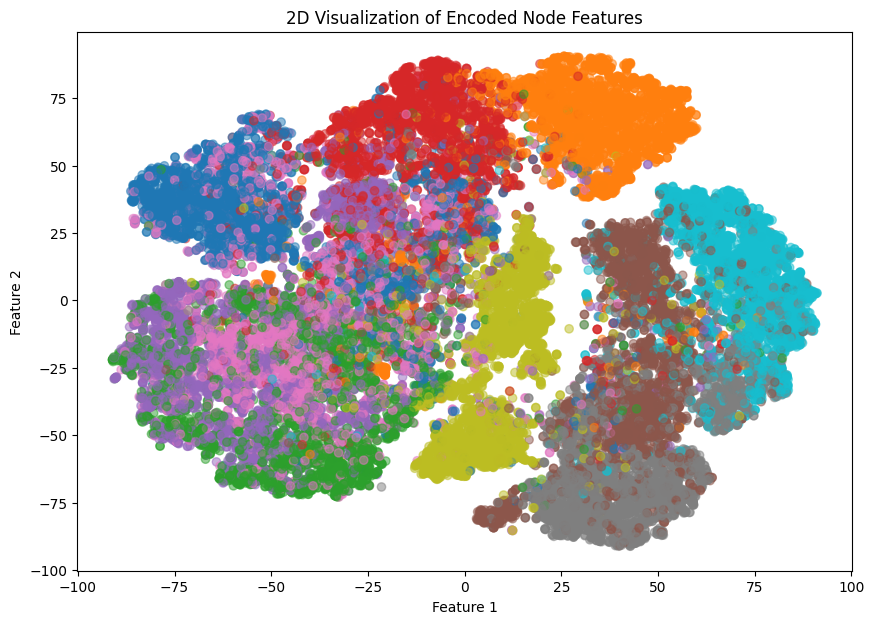

In [7]:
from sklearn.manifold import TSNE

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(encoded_features)

visualise(tsne_results, labels, '2D Visualization of Encoded Node Features')

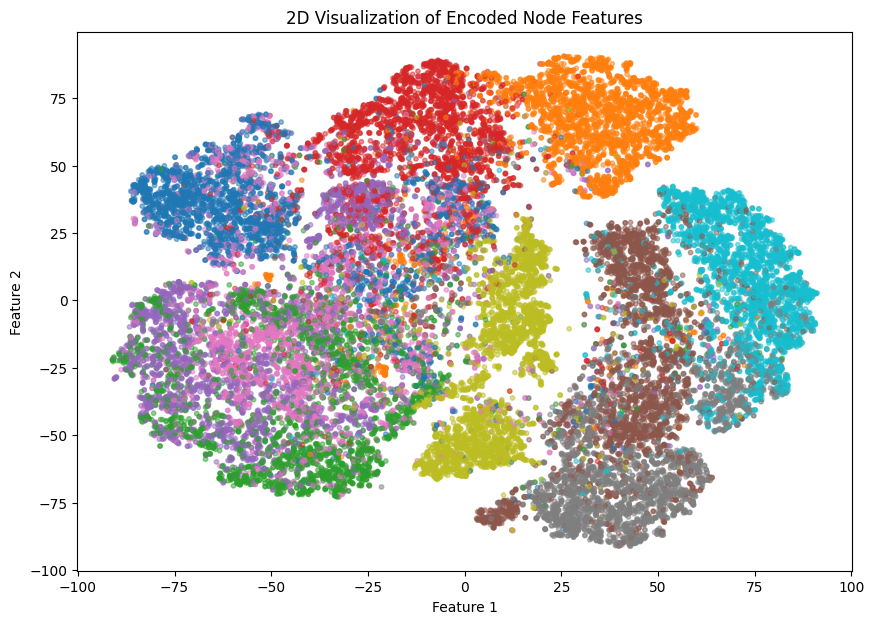

In [9]:
visualise(tsne_results, labels, '2D Visualization of Encoded Node Features', size=10)